# Magnetic Inversion
---------------------
* Due date: December 10th, 2025 

## Objectives
Perform a 3D generalized magnetics inversion of a sample data set and make an interpretation of the subsurface from visualizations of the recovered model.

1. Perform the 3D inversion
1. Make some simple 2D plots of slices through the model
1. Make some 3D visualizations of the model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mag_utils.mag_inv import setup_data, setup_mesh, get_simulation, run_inversion
import pyvista as pv
pv.set_jupyter_backend('trame')

## Background
This notebook runs a simple magnetics inversion of the data provided. It does most of the work in setting up an inversion (using SimPEG) and running it. Most of your time will be spent playing and learning how to visualize the recoverd model in 3D to help support your interpretation.

You are provided with a synthetic airborne magnetics data set, shown in below. There is no topography in this example, and the flight surface is a horizontal plane.

In [ ]:
data_mag = setup_data('data/Lab13_data.csv')
data_mag.nD

In [ ]:
# let's plot up the data:
data_loc = data_mag.survey.receiver_locations
plt.tripcolor(data_loc[:, 0], data_loc[:, 1], data_mag.dobs, shading='gouraud')
plt.title('Total Field Anomaly')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
cb = plt.colorbar()
cb.set_label('nT')

The surface geology is simple, there are two surface expressions of a magnetite rich ore.

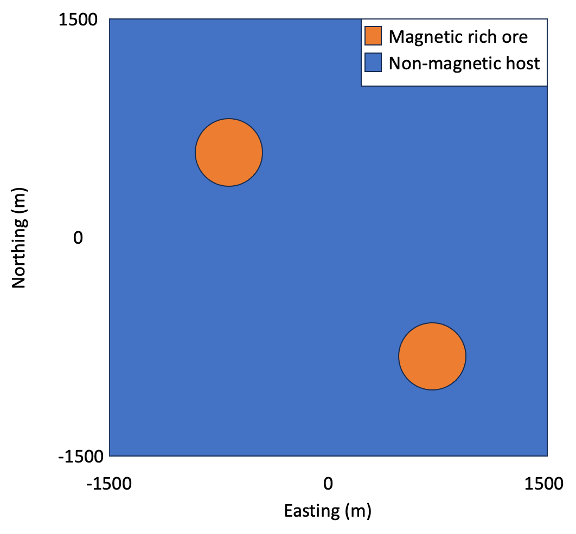

Your goal is simple: determine if it’s possible that these two surface expressions are connected. If it is, how deep does the anomalous body extend?

#### Visualization libraries
This lab makes use of a 3D visualization package called `pyvista`. It is a convenient python interface to the visualization tool kit package (VTK). There are many options and examples of how to use it available at the package’s documentation: https://docs.pyvista.org/

## Tasks
### Inversion
1. First read in and plot the provided data set, make sure your image looks reasonable.
2. Setup the Octree mesh used for the inversion
3. Setup the simulation object (which handles the forward modeling responsibilities)
4. Run the inversion
    * You can play with some of the default options here to see how they affect the recovered model (Such as setting different length scales for x and y).

In [ ]:
# this is a 3D discretize.TreeMesh
mesh = setup_mesh(data_mag.survey, dh=50)
mesh

In [ ]:
# setup simulation
sim = get_simulation(mesh, data_mag.survey)

This inversion is solving the problem:

$$\min_m \phi(m) = \phi_d(m) + \beta \phi_m(m)$$

with the data misfit simply defined as:
$$\phi_d(m) = |W_d(A m - d)|^2 $$

and the model objective function defined as:
$$
\phi_m(m) = \alpha_s\int_m m dV + \alpha_x \int_m \frac{\partial m}{\partial_x} dV + \alpha_y \frac{\partial m}{\partial_y} dV + \alpha_z\frac{\partial m}{\partial_z} dV
$$

with $\alpha_{x,y,z}$ defined in terms of length scales as:
$$
\alpha_x = L_x^2\Delta h
$$

In [ ]:
model = run_inversion(
    data_mag,
    sim,
    alpha_s=None,
    length_scale_x=None,
    length_scale_y=None,
    length_scale_z=None,
    reference_model=None,
    max_iter=20,
)

In [ ]:
# Plot up the predicted data set:
dpred = sim.dpred(model)

# here we plot both the predicted and the difference between the predicted and observed data.
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.tripcolor(data_loc[:, 0], data_loc[:, 1], dpred, shading='gouraud')
plt.title('Predicted')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
cb = plt.colorbar()
cb.set_label('nT')

plt.subplot(1,2,2)
plt.title('Data Difference')
plt.tripcolor(data_loc[:, 0], data_loc[:, 1], data_mag.dobs - dpred, shading='gouraud', cmap='seismic')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
cb = plt.colorbar()
cb.set_label('nT')

plt.tight_layout()

### Simple visualization
The discretize mesh has some simple plotting operations. Make use of them to investigate your model by slicing along each x, y, and z axis.

1.	Plot three slices (1 each normal to the x, y, and z axis) that you believe will support your interpretation.

Question: What do you think the overall shape of the anomalous body is?

In [ ]:
ax = plt.subplot(111)
im, = mesh.plot_slice(model, slice_loc=-100, normal='z', clim=[0, 0.12], ax=ax)
ax.set_xlim([-1500, 1500])
ax.set_ylim([-1500, 1500])
plt.colorbar(im)

Try out some more simple plots with different orientations and locations yourself to try to get an understanding of the 3D model.

In [ ]:
# TODO make more 2D plots!

### 3D visualization
Make use of `pyvista` to create 3D images of your recovered model.

1. Play around with rotating the model in 3D, you can drag your mouse to rotate, scroll to zoom in and out, shift+drag to move the model. Click some of the different options on the top of the figure to see what they do.
2. Use `pyvista` to create a single three-dimensional image that you feel best supports your interpretation.


The first step is to convert the `discretize.TreeMesh` into a `pyvista` mesh, fortunately these packages interact well with each other and you can do this simply:

In [ ]:
pv_mesh = mesh.to_vtk(models={'chi':model})
pv_mesh.set_active_scalars('chi')

Like the simple plotting, we usually would like to extract the core region of the mesh.
Like above, lets cutout the core region bounded by the data, with about 1000m depth.

In [ ]:
# first let's cutout the padding zones
core = pv_mesh.clip_box(bounds=[-1500, 1500, -1500,1500, -1000, 0], invert=False)

In [ ]:
# play around with the 3D plot of the core region to grasp the controls.
core.plot(clim=[0,0.12])

`pyvista` has many ways to manipulate and "filter" meshes to create your image, for example you can slice through your model with any plane orientation you like!

In [ ]:
# plot a diagonal slice through the center of the model
slc = core.slice(normal=[1, 1, 0], origin=[0,0,0])
slc.plot(jupyter_backend='trame', clim=[0,0.12])

Or let's say you want to threshold your model, and only show cells above a certain value.

In [ ]:
thresh = pv_mesh.threshold(0.035)
thresh.plot(jupyter_backend='trame', clim=[0,0.12])

What if I want to plot a slice and a threshold at the same time? Then we can make a `block` of all our meshes!

In [ ]:
blocks = pv.MultiBlock([thresh, slc])
blocks.plot(clim=[0,0.12])

In [ ]:
# or make multiple slices!

slices = []
normal = np.array([1, 1, 0])
origin = np.array([0, 0, 0])
for offset in np.linspace(-1000, 1000, 5):
    slices.append(core.slice(normal=normal, origin=origin + offset*normal))

blocks = pv.MultiBlock(slices)
blocks.plot(clim=[0,0.12])

In [ ]:
## TODO Make your own 3D scene!

## Deliverables
Submit an informal report detailing:

1. Your name, lab title
2. Plots of your data
3. Plots of your predicted data and the difference
4. Your interpretation of the recovered model
   * Does it connect?
   * How deep does it go?
   * It’s shape?
   * etc.
5.	2D images of slices along each axis
6.	3D image best supporting your interpretation
7.	Conclusions